In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v006.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, tqdm
import numpy as np
import xarray as xr
import torch

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../mre_ai')
#import mre_ai.mre_datasets

torch.cuda.is_available()

Using backend: pytorch



True

## Process images for a single patient

- load SITK images from NIFTI files
- perform filtering/inpainting on wave image
- register images wrt anatomical image
- load segmentation model
- perform image segmentation
- convert images to xarray Dataset

In [3]:
%autoreload
patient = mre_pinn.data.ImagingPatient('0006')
patient.load_images()
patient.metadata

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/mre.nii


size    spacing      origin       limit      center  \
sequence     dimension                                                        
t1_pre_in    0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_water 0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_out   0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_fat   0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t2           0           256   1.406300 -200.263000  158.343486  -20.959757   
             1           256   1.406300 -208.240997  150.365490  -28.937754   
             2            23  10.000000 -154.516006   65.483994  -44.516006   
mre_raw      0           256   1.406300 -206.904007  151.702480  -27.600763   
             1           256   1.406300 -195.858994  162.747493  -16.555750   
             2             4   1.000000    0.000000    3.000000    1.500000   
wave         0           512   1.000000    0.000000  511.000000  255.500000   
             1           512   1.000000    0.000000  511.000000  255.500000   
             2             4   1.000000    0.000000    3.000000    1.500000   
mre          0           256   1.406300 -206.904007  151.702480  -27.600763   
             1           256   1.406300 -195.858994  162.747493  -16.555750   
             2             4  11.000000   -1.056400   31.943600   15.443600   

                            extent  
sequence     dimension              
t1_pre_in    0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_water 0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_out   0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_fat   0          359.987213  
             1          359.987213  
             2          202.400269  
t2           0          360.012787  
             1          360.012787  
             2          230.000000  
mre_raw      0          360.012787  
             1          360.012787  
             2            4.000000  
wave         0          512.000000  
             1          512.000000  
             2            4.000000  
mre          0          360.012787  
             1          360.012787  
             2           44.000000

In [4]:
%autoreload
patient.preprocess()

Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55921fd74220)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 36498
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -27.6008 -16.5558 15.4436)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -207.243 -196.198 -84.6065)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7031 0.7031 2

In [5]:
patient.metadata

size    spacing      origin       limit     center  \
sequence     dimension                                                       
t1_pre_in    0           256   1.406200 -206.891270  151.689743 -27.600763   
             1           256   1.406200 -195.846257  162.734756 -16.555750   
             2            16  12.650017  -79.431526  110.318726  15.443600   
t1_pre_water 0           256   1.406200 -206.891270  151.689743 -27.600763   
             1           256   1.406200 -195.846257  162.734756 -16.555750   
             2            16  12.650017  -79.431526  110.318726  15.443600   
t1_pre_out   0           256   1.406200 -206.891270  151.689743 -27.600763   
             1           256   1.406200 -195.846257  162.734756 -16.555750   
             2            16  12.650017  -79.431526  110.318726  15.443600   
t1_pre_fat   0           256   1.406200 -206.891270  151.689743 -27.600763   
             1           256   1.406200 -195.846257  162.734756 -16.555750   
             2            16  12.650017  -79.431526  110.318726  15.443600   
t2           0           256   1.406200 -206.891270  151.689743 -27.600763   
             1           256   1.406200 -195.846257  162.734756 -16.555750   
             2            16  12.650017  -79.431526  110.318726  15.443600   
mre_raw      0           256   1.406300 -206.904007  151.702480 -27.600763   
             1           256   1.406300 -195.858994  162.747493 -16.555750   
             2             4  11.000000   -1.056400   31.943600  15.443600   
wave         0           256   1.406300 -206.904007  151.702480 -27.600763   
             1           256   1.406300 -195.858994  162.747493 -16.555750   
             2             4  11.000000   -1.056400   31.943600  15.443600   
mre          0           256   1.406300 -206.904007  151.702480 -27.600763   
             1           256   1.406300 -195.858994  162.747493 -16.555750   
             2             4  11.000000   -1.056400   31.943600  15.443600   
anat_mask    0           256   1.406200 -206.891270  151.689743 -27.600763   
             1           256   1.406200 -195.846257  162.734756 -16.555750   
             2            16  12.650017  -79.431526  110.318726  15.443600   
mre_mask     0           256   1.406300 -206.904007  151.702480 -27.600763   
             1           256   1.406300 -195.858994  162.747493 -16.555750   
             2             4  11.000000   -1.056400   31.943600  15.443600   

                            extent  
sequence     dimension              
t1_pre_in    0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_water 0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_out   0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_fat   0          359.987213  
             1          359.987213  
             2          202.400269  
t2           0          359.987213  
             1          359.987213  
             2          202.400269  
mre_raw      0          360.012787  
             1          360.012787  
             2           44.000000  
wave         0          360.012787  
             1          360.012787  
             2           44.000000  
mre          0          360.012787  
             1          360.012787  
             2           44.000000  
anat_mask    0          359.987213  
             1          359.987213  
             2          202.400269  
mre_mask     0          360.012787  
             1          360.012787  
             2           44.000000

Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray


<IPython.core.display.Javascript object>


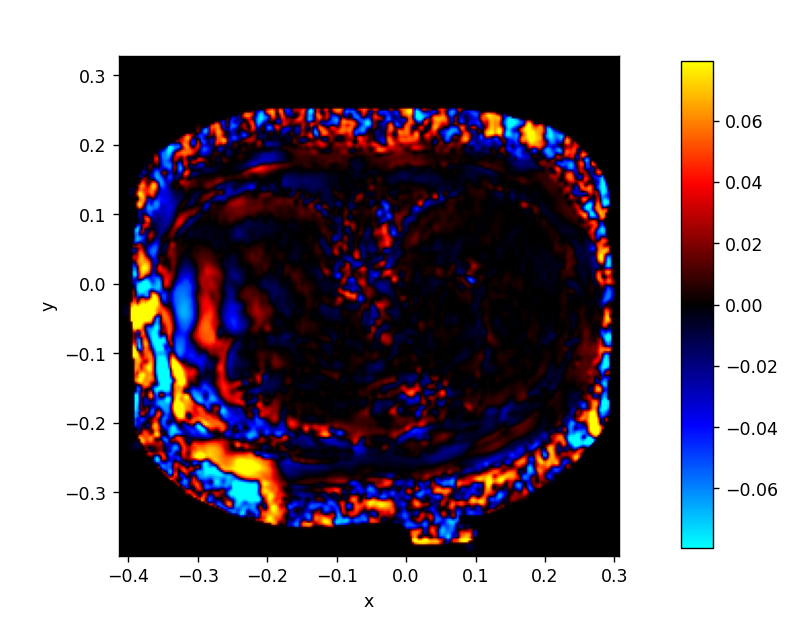

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


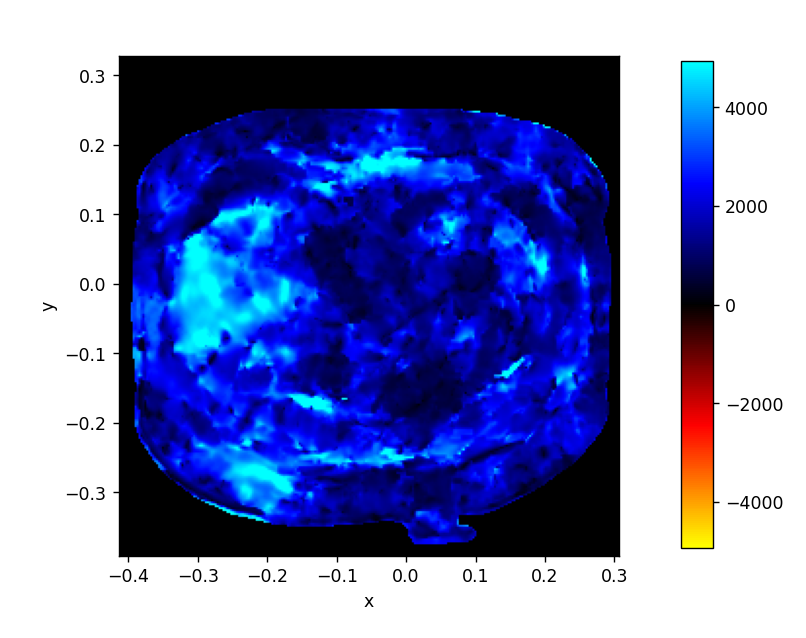

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


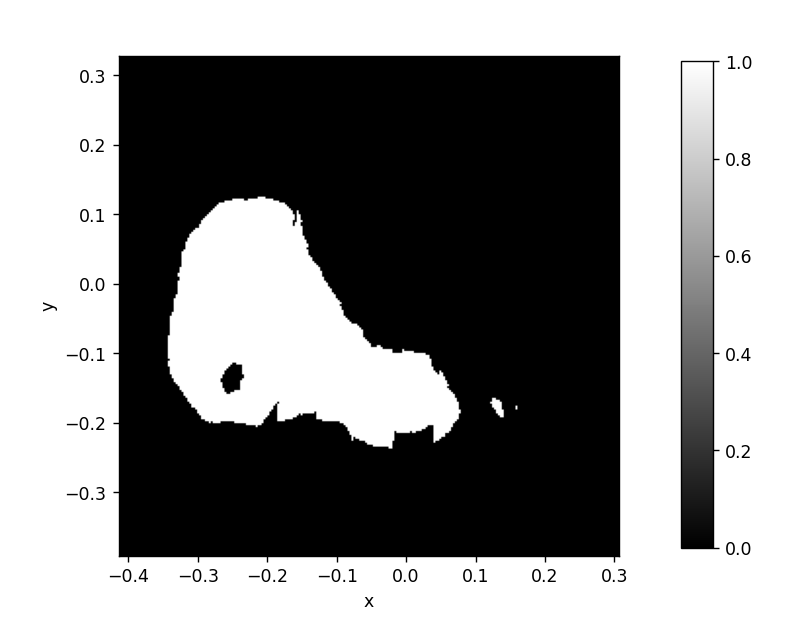

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


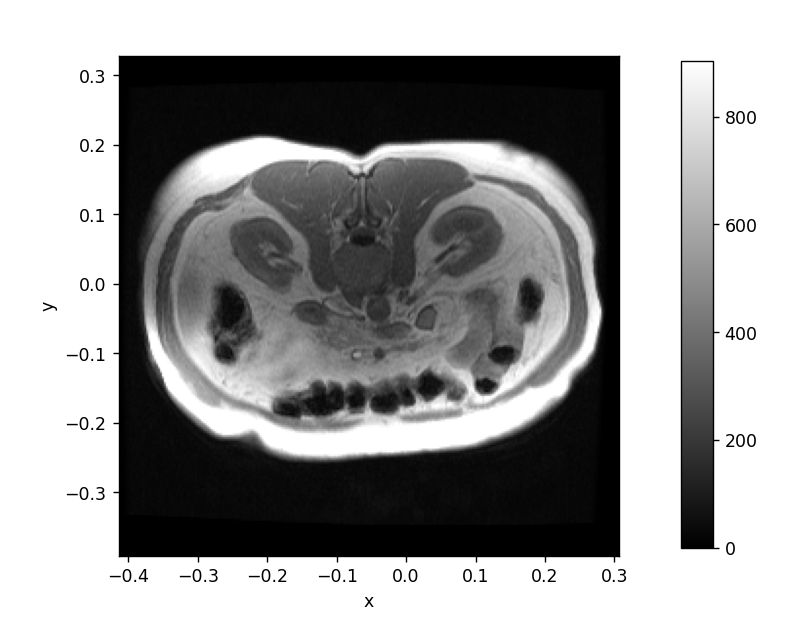

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


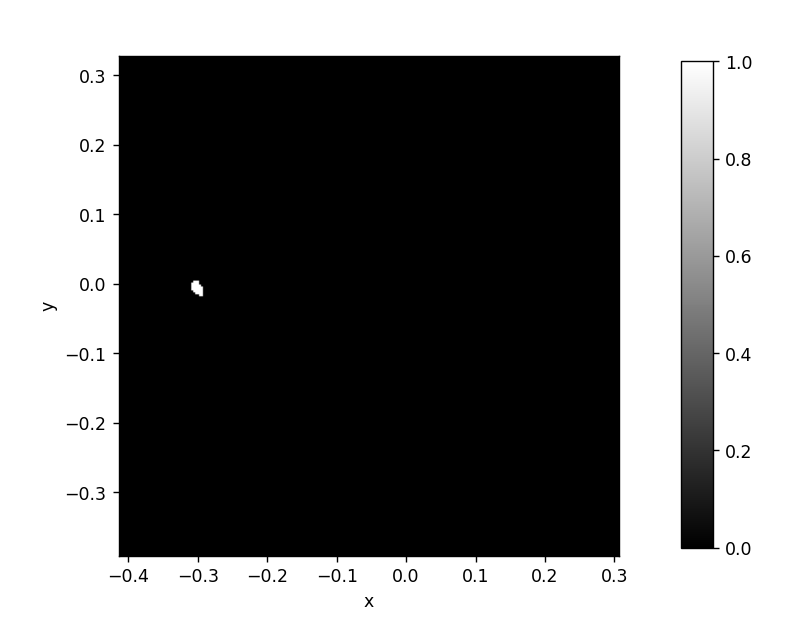

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [6]:
%autoreload
example = mre_pinn.data.MREExample.from_patient(patient)
example.view()

In [8]:
example.save_xarrays('../data/NAFLD/test/')

Writing ../data/NAFLD/test/0006/wave.nc
Writing ../data/NAFLD/test/0006/mre.nc
Writing ../data/NAFLD/test/0006/mre_mask.nc
Writing ../data/NAFLD/test/0006/anat.nc
Writing ../data/NAFLD/test/0006/anat_mask.nc


In [9]:
%autoreload
example = mre_pinn.data.MREExample.load_xarrays('../data/NAFLD/test/', '0006')
example.metadata

Loading ../data/NAFLD/test/0006/wave.nc
Loading ../data/NAFLD/test/0006/mre.nc
Loading ../data/NAFLD/test/0006/mre_mask.nc


size   spacing    origin     limit    center    extent
variable dimension                                                        
wave     x           256  0.002813 -0.413808  0.303405 -0.055202  0.720026
         y           256  0.002813 -0.391718  0.325495 -0.033112  0.720026
         z             4  0.022000 -0.002113  0.063887  0.030887  0.088000
mre      x           256  0.002813 -0.413808  0.303405 -0.055202  0.720026
         y           256  0.002813 -0.391718  0.325495 -0.033112  0.720026
         z             4  0.022000 -0.002113  0.063887  0.030887  0.088000
mre_mask x           256  0.002813 -0.413808  0.303405 -0.055202  0.720026
         y           256  0.002813 -0.391718  0.325495 -0.033112  0.720026
         z             4  0.022000 -0.002113  0.063887  0.030887  0.088000

## Process images for a patient cohort

In [10]:
with open('/ocean/projects/asc170022p/shared/Data/MRE/gold.txt') as f:
    patient_ids = [line.split('.')[0].split('_')[1] for line in f]

len(patient_ids)

181

In [11]:
%autoreload
cohort = mre_pinn.data.ImagingCohort(patient_ids='{' + ','.join(patient_ids) + '}')
len(cohort)

/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0830 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0838 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0846 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0860 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0872 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1474 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1483 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1495 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1504 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1526 

155

In [12]:
%%time
cohort.load_images()

  0%|          | 0/155 [00:00<?, ?it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/mre.nii
  1%|          | 1/155 [00:01<03:27,  1.35s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0900/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFT

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/mre.nii
  7%|▋         | 11/155 [00:22<06:28,  2.70s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t2.nii
Loading /ocean/projects

 14%|█▎        | 21/155 [00:36<03:13,  1.44s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/mre.nii
 14%|█▍        | 22/155 [00:37<02:51,  1.29s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1108/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/mre.nii
 21%|██        | 32/155 [00:49<02:05,  1.02s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t2.nii
Loading /ocean/projects

 27%|██▋       | 42/155 [01:00<02:07,  1.13s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/mre.nii
 28%|██▊       | 43/155 [01:01<02:08,  1.14s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1343/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/mre.nii
 34%|███▍      | 53/155 [01:17<03:22,  1.98s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t2.nii
Loading /ocean/projects

 41%|████      | 63/155 [01:28<01:35,  1.04s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/mre.nii
 41%|████▏     | 64/155 [01:29<01:51,  1.23s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0126/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFT

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0384/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0384/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0384/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0384/mre.nii
 48%|████▊     | 74/155 [01:40<01:35,  1.18s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/mre_raw.nii
Loading /ocean/projects/asc170022p/s

 54%|█████▍    | 84/155 [01:57<01:35,  1.35s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/mre.nii
 55%|█████▍    | 85/155 [01:58<01:32,  1.32s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0457/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFT

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0564/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0564/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0564/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0564/mre.nii
 61%|██████▏   | 95/155 [02:09<01:04,  1.08s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/mre_raw.nii
Loading /ocean/projects/asc170022p/s

 68%|██████▊   | 105/155 [02:20<00:59,  1.18s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/mre.nii
 68%|██████▊   | 106/155 [02:22<00:58,  1.20s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0704/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NI

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1679/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1679/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1679/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1679/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1679/mre.nii
 75%|███████▍  | 116/155 [02:33<00:49,  1.27s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t2.nii
Loading /ocean/projects/asc17002

 81%|████████▏ | 126/155 [02:43<00:30,  1.06s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/mre.nii
 82%|████████▏ | 127/155 [02:44<00:28,  1.03s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1785/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NI

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/mre.nii
 88%|████████▊ | 137/155 [02:55<00:19,  1.07s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/mre_raw.nii
Loading /ocean/projects/asc170022p/

 95%|█████████▍| 147/155 [03:09<00:11,  1.48s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/mre.nii
 95%|█████████▌| 148/155 [03:10<00:09,  1.37s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1948/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NI

In [14]:
%%time
cohort.preprocess()

Loading segmentation model
  0%|          | 0/155 [00:00<?, ?it/s]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592e59099d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 546915
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.538 -45.776 158.963)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.125 -255.363 22.1128)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePi

  1%|          | 1/155 [00:51<2:10:56, 51.02s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559251a33150)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 787184
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 8.49001 -40.622 97.0866)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -186.124 -235.236 -2.96341)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float"

  1%|▏         | 2/155 [01:33<1:57:01, 45.89s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592e58dcfe0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 1027433
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -14.1432 -20.0002 129.457)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.765 -219.622 1.80725)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

  2%|▏         | 3/155 [02:22<1:59:53, 47.32s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559298c9dc40)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 1267237
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -14.7098 -19.9938 56.6948)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -194.352 -199.636 -43.355)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

  3%|▎         | 4/155 [03:05<1:54:27, 45.48s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592e59054e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 1507544
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -37.9233 -22.5813 32.6316)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -227.555 -212.213 -85.8186)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

  3%|▎         | 5/155 [03:51<1:54:58, 45.99s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592951f6450)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 1747885
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -41.8383 28.0817 110.295)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -211.516 -141.596 1.04483)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float

  4%|▍         | 6/155 [04:36<1:52:51, 45.44s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559299394980)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 1987912
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 19.663 -24.294 28.3346)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -169.969 -213.926 -80.9155)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float"

  5%|▍         | 7/155 [05:20<1:50:55, 44.97s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592952095b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 2228062
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 23.9535 -38.9105 96.2272)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -195.623 -258.487 -13.0228)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

  5%|▌         | 8/155 [06:04<1:49:34, 44.73s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559298ca1ee0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 2468115
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -21.5945 -44.0665 -12.9166)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -231.181 -253.653 -122.167)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

  6%|▌         | 9/155 [06:48<1:48:36, 44.64s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592e5874400)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 2708067
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.26324 -38.9073 51.5384)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.885 -238.529 -76.1118)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

  6%|▋         | 10/155 [07:37<1:51:09, 46.00s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55921f71e5c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 2948342
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 1.60875 -21.7222 1.6932)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -178.033 -201.364 -135.156)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

  7%|▋         | 11/155 [08:30<1:54:51, 47.86s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55929939b1a0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 3188654
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.4128 -19.9938 10.2872)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -190.055 -199.636 -89.7623)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

  8%|▊         | 12/155 [09:11<1:49:40, 46.02s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559298ca1ee0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 3428715
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.83825 -20.0048 155.741)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -231.693 -259.536 37.291)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float

  8%|▊         | 13/155 [09:57<1:48:58, 46.05s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592956bf1a0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 3668740
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -0.962995 -28.591 250.919)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -190.595 -218.223 132.469)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

  9%|▉         | 14/155 [10:44<1:48:36, 46.22s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592e586b9a0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 3908883
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 4.18974 -20.0002 54.976)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -195.432 -219.622 -45.0698)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

 10%|▉         | 15/155 [11:26<1:45:00, 45.01s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592914c3a70)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 4149087
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.4193 -20.0002 54.1166)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -210.041 -219.622 -55.1335)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 10%|█         | 16/155 [12:10<1:43:08, 44.52s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559295cfcfe0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 4389314
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 10.2057 -40.6252 64.4294)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -209.371 -260.202 -44.8204)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 11%|█         | 17/155 [12:54<1:42:21, 44.50s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559298ca1ee0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 4629274
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -1.82199 -34.607 105.681)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -191.454 -224.239 -21.9685)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 12%|█▏        | 18/155 [13:43<1:44:32, 45.78s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592914dc120)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 4869003
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 14.223 -45.776 56.6948)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -205.354 -265.353 -61.7554)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float

 12%|█▏        | 19/155 [14:29<1:43:59, 45.88s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559299399e80)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 5109316
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 15.5188 -56.0952 83.7631)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -194.068 -265.682 -54.9869)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 13%|█▎        | 20/155 [15:18<1:45:22, 46.83s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559298c98310)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 5349463
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -29.32 -27.513 97.0866)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -248.897 -247.09 -30.5636)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float"

 14%|█▎        | 21/155 [16:07<1:45:48, 47.38s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55921f71e5c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 5589481
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -38.7835 -38.9105 152.733)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -248.37 -248.497 52.683)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float

 14%|█▍        | 22/155 [16:48<1:41:16, 45.69s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559295411560)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 5829683
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -12.777 -60.815 86.9886)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -232.354 -280.392 -45.2497)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

 15%|█▍        | 23/155 [17:39<1:43:25, 47.01s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559299387a70)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 6069849
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -12.1382 -38.9073 51.5384)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -211.76 -238.529 -57.7114)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 15%|█▌        | 24/155 [18:23<1:41:00, 46.26s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592914b3e60)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 6309818
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 0.755999 -35.466 -4.3226)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -188.876 -225.098 -122.773)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 16%|█▌        | 25/155 [19:10<1:40:32, 46.41s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559295409e70)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 6550016
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.63424 -33.7438 63.57)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -181.998 -223.376 -54.8798)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float

 17%|█▋        | 26/155 [19:56<1:39:32, 46.30s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559295d0fb60)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 6790245
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 33.413 -23.434 38.6474)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -156.219 -213.066 -70.602)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float"

 17%|█▋        | 27/155 [20:40<1:37:13, 45.57s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559295d07db0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 7030459
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 5.04649 -42.3475 6.8496)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.54 -251.934 -111.601)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float

 18%|█▊        | 28/155 [21:26<1:36:40, 45.67s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55921f71eff0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 7270733
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 18.806 -19.994 240.72)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -200.771 -239.571 122.27)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")


 19%|█▊        | 29/155 [22:12<1:36:20, 45.88s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55929258df90)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 7510684
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -16.432 -20.856 23.1782)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -206.064 -210.488 -86.0716)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

 19%|█▉        | 30/155 [22:56<1:34:34, 45.39s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559295daa4e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 7750781
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 1.61475 -54.3732 20.6)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -227.926 -283.914 -79.4498)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float"

 20%|██        | 31/155 [23:38<1:31:38, 44.34s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592e58efee0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 7991088
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 10.7755 -61.5405 22.6053)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -198.811 -271.127 -77.4448)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 21%|██        | 32/155 [24:20<1:29:19, 43.57s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559295dc7460)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 8231292
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 28.257 -19.997 103.962)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -161.375 -209.629 -5.28798)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float

 21%|██▏       | 33/155 [25:04<1:28:37, 43.59s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592953e66c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 8471094
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.6275 -75.8605 195.918)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -231.904 -315.392 68.2679)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float

 22%|██▏       | 34/155 [25:51<1:30:31, 44.89s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592953f3d60)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 8711361
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.98225 -56.0952 38.6474)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -216.569 -265.682 -61.4027)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 23%|██▎       | 35/155 [26:33<1:27:44, 43.87s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55929130ad20)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 8951578
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -2.68851 -38.2655 182.812)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -202.311 -237.888 73.562)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

 23%|██▎       | 36/155 [27:17<1:26:57, 43.84s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559298d52420)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 9191776
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.413 -46.635 176.438)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -229.99 -266.212 48.788)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")

 24%|██▍       | 37/155 [28:06<1:29:26, 45.48s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592914ad280)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 9432085
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.979 -19.997 20.6)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -196.611 -209.629 -88.6494)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")


 25%|██▍       | 38/155 [28:50<1:27:41, 44.97s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55921f6b3820)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 9672207
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 24.8158 -32.0312 56.6948)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -174.806 -231.653 -52.5553)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 25%|██▌       | 39/155 [29:33<1:26:10, 44.58s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559298ca2ae0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 9912056
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -4.40425 -26.0163 85.9144)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.026 -225.638 -14.1356)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 26%|██▌       | 40/155 [30:15<1:23:49, 43.73s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592951fa330)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 10152025
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 17.6577 -62.6802 192.48)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -201.919 -282.257 64.83)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float"

 26%|██▋       | 41/155 [31:04<1:25:48, 45.16s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55929131a0d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 10392223
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.631 -19.997 71.3046)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -182.001 -209.629 -37.9452)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float

 27%|██▋       | 42/155 [31:48<1:24:27, 44.84s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592956d6470)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 10632151
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 42.2908 -27.1613 218.262)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -147.341 -216.793 99.8118)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 28%|██▊       | 43/155 [32:34<1:24:23, 45.21s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559295dc7620)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 10872293
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 38.5658 -45.7823 36.9286)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -161.056 -245.404 -81.5208)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 28%|██▊       | 44/155 [33:20<1:24:15, 45.54s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55921ec49000)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 11112344
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.5475 -44.0665 143.494)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.134 -253.653 15.844)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

 29%|██▉       | 45/155 [34:09<1:25:18, 46.53s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55921f6b0910)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 11352319
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 26.827 -48.354 195.918)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -182.76 -257.941 77.468)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")

 30%|██▉       | 46/155 [34:55<1:24:05, 46.29s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55921f8d49d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 11592530
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 25.6747 -20.0002 80.758)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -173.947 -219.622 -46.8922)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 30%|███       | 47/155 [35:43<1:24:23, 46.89s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592953fadf0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 11832880
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 17.2235 -12.9335 129.084)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -172.409 -202.566 1.43404)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 31%|███       | 48/155 [36:31<1:24:23, 47.32s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592912f4110)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 12073053
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 48.0167 -37.1913 151.229)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -161.16 -246.368 41.979)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float

 32%|███▏      | 49/155 [36:57<1:12:05, 40.80s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592951ffed0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 12313140
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 11.928 -19.997 33.491)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -177.704 -209.629 -66.5591)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float

 32%|███▏      | 50/155 [37:39<1:11:52, 41.08s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559292582a10)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 12552956
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -13.854 -19.997 52.3978)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -203.486 -209.629 -66.0524)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 33%|███▎      | 51/155 [38:25<1:13:43, 42.54s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55921f8b3520)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 12793016
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 11.502 -57.592 161.971)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -218.039 -287.133 25.1208)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float

 34%|███▎      | 52/155 [39:15<1:17:03, 44.88s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559292570cd0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 13033164
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 15.366 -19.997 24.897)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -174.266 -209.629 -84.3524)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float

 34%|███▍      | 53/155 [39:59<1:15:42, 44.54s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55921f8b3520)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 13273516
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.53776 -19.9938 182.167)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -183.18 -199.636 54.5169)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 35%|███▍      | 54/155 [40:47<1:17:00, 45.75s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55929541e4d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 13513735
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 4.19301 -19.997 34.3504)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -185.439 -209.629 -74.8994)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 35%|███▌      | 55/155 [41:32<1:15:31, 45.31s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559292585000)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 13754036
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -4.40425 -36.3282 50.679)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.991 -245.915 -67.7708)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 36%|███▌      | 56/155 [42:18<1:15:13, 45.59s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592987876f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 13994315
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 24.8125 -41.4885 59.273)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -184.774 -251.075 -59.1772)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 37%|███▋      | 57/155 [43:04<1:14:45, 45.77s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55921f6b3270)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 14234281
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 10.852 -19.998 82.9065)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -178.78 -209.63 -35.5437)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float"

 37%|███▋      | 58/155 [43:50<1:14:11, 45.89s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559299f12340)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 14474434
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -27.6008 -16.5558 15.4436)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -207.243 -196.198 -84.6065)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 38%|███▊      | 59/155 [44:32<1:11:25, 44.64s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592987bade0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 14714337
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 3.33075 -38.0473 72.164)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -196.291 -237.669 -37.0858)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 39%|███▊      | 60/155 [45:16<1:10:14, 44.36s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559299f1d120)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 14954520
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -16.4288 -21.7128 14.5842)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -206.061 -211.345 -85.4225)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 39%|███▉      | 61/155 [45:58<1:08:23, 43.66s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592b6603b20)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 15194349
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 3.33075 -38.0473 72.164)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -196.291 -237.669 -37.0858)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 40%|████      | 62/155 [46:41<1:07:41, 43.67s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592b65767b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 15434505
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 1.61825 -19.9938 47.2414)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -178.024 -199.636 -62.0087)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 41%|████      | 63/155 [47:25<1:07:07, 43.77s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592914d2f20)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 15674152
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 16.837 -22.471 223.653)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -172.795 -212.103 123.603)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float

 41%|████▏     | 64/155 [48:07<1:05:26, 43.15s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55929257ba00)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 15914268
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.542 -51.505 149.506)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -225.119 -271.082 21.856)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float"

 42%|████▏     | 65/155 [48:56<1:07:07, 44.75s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592956b6590)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 16154447
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 23.96 -24.294 79.0392)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -165.672 -213.926 -39.4106)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float

 43%|████▎     | 66/155 [49:42<1:07:00, 45.18s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592951fa490)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 16394448
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -25.886 -37.185 36.0692)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -215.518 -226.817 -82.381)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

 43%|████▎     | 67/155 [50:28<1:06:43, 45.50s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559292579530)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 16633906
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -8.54324 -20.0002 90.1312)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -217.72 -229.177 -28.319)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 44%|████▍     | 68/155 [50:54<57:27, 39.63s/it]  Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559299f0b0f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 16874144
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -11.6682 -40.8333 134.923)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -211.29 -240.455 16.473)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

 45%|████▍     | 69/155 [51:40<59:39, 41.62s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592913139f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 17114043
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -19.8763 -20.0033 103.962)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -209.508 -209.635 -5.28835)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 45%|████▌     | 70/155 [52:24<59:55, 42.30s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592912f4110)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 17354338
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -25.886 -38.904 61.8512)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -225.508 -238.526 -38.1988)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float

 46%|████▌     | 71/155 [53:06<59:08, 42.25s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592b6cf16b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 17594480
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -30.1862 -48.3602 44.6632)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -229.808 -247.982 -64.5866)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 46%|████▋     | 72/155 [53:51<59:30, 43.02s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55921f6751f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 17834539
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -21.589 -19.997 -25.8076)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -211.221 -209.629 -144.258)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

 47%|████▋     | 73/155 [54:37<1:00:02, 43.93s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObjectTransforming t1_pre_out (0x5592b81e7d70)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 18074764
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.25675 -19.9938 45.5226)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -184.899 -199.636 -54.5272)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (

 48%|████▊     | 74/155 [55:19<58:40, 43.46s/it]  Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592956c3290)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 18314859
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -4.39776 -20.8528 25.7564)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -184.04 -200.495 -74.2937)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 48%|████▊     | 75/155 [56:02<57:33, 43.17s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559299f28410)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 18555024
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -4.36751 -35.0425 283.247)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.954 -244.629 155.597)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

 49%|████▉     | 76/155 [56:52<59:39, 45.31s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592bfb56bd0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 18795092
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.62775 -48.3602 38.6474)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -191.994 -247.982 -70.6027)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

 50%|████▉     | 77/155 [57:36<58:28, 44.98s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592bf480930)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 19035049
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 9.56149 -50.0795 217.832)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -219.98 -279.621 71.7833)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float"

 50%|█████     | 78/155 [58:30<1:01:10, 47.67s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592bcb1ec40)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 19275327
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 8.4835 -42.1325 134.685)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -201.103 -251.719 7.03504)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

 51%|█████     | 79/155 [59:19<1:00:38, 47.87s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c08b3f50)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 19515412
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -19.0068 -19.9938 13.7248)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -208.639 -209.626 -104.725)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 52%|█████▏    | 80/155 [1:00:09<1:00:54, 48.72s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592b81e7d70)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 19755722
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 10.889 -44.343 232.554)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -208.688 -263.92 104.904)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

 52%|█████▏    | 81/155 [1:00:58<1:00:00, 48.66s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559298d62850)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 19996014
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 53.182 -44.863 234.793)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -166.395 -264.44 125.543)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

 53%|█████▎    | 82/155 [1:01:42<57:40, 47.40s/it]  Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c2df8020)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 20236318
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -25.026 -19.137 75.6016)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -224.648 -218.759 -24.4484)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 54%|█████▎    | 83/155 [1:02:25<54:58, 45.82s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c1f29d00)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 20476358
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -27.604 -24.294 65.2888)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -217.236 -213.926 -53.1614)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 54%|█████▍    | 84/155 [1:03:11<54:25, 45.99s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c01e26d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 20716057
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 8.49325 -26.0098 37.788)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -171.149 -205.652 -71.4622)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 55%|█████▍    | 85/155 [1:03:55<53:01, 45.44s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c3420960)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 20956239
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -26.745 -19.997 25.7564)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -216.377 -209.629 -74.2937)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 55%|█████▌    | 86/155 [1:04:37<51:05, 44.43s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592baa089d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 21196321
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 3.334 -25.153 42.9444)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -191.28 -219.767 -57.1057)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float"

 56%|█████▌    | 87/155 [1:05:19<49:27, 43.64s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592bcb17c00)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 21436590
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 19.663 -19.997 -10.3384)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -169.969 -209.629 -119.589)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 57%|█████▋    | 88/155 [1:06:03<48:48, 43.71s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55921f674ec0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 21676880
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 0.749494 -32.0345 -23.2294)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -203.855 -236.639 -141.68)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 57%|█████▋    | 89/155 [1:06:49<48:46, 44.34s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592bf7ce190)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 21917071
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.33751 -51.4485 180.367)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -222.914 -271.025 43.517)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 58%|█████▊    | 90/155 [1:07:40<50:24, 46.53s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c27064c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 22157164
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 0.759237 -18.2748 12.8654)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -178.883 -197.917 -87.1847)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 59%|█████▊    | 91/155 [1:08:23<48:17, 45.27s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559298d6d230)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 22397004
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -32.4448 -19.9938 163.651)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -212.087 -199.636 45.2009)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 59%|█████▉    | 92/155 [1:09:09<47:52, 45.60s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592956d13e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 22636923
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 24.8158 -44.0632 10.2872)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -174.806 -243.685 -98.9629)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 60%|██████    | 93/155 [1:09:53<46:30, 45.02s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592956d32f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 22877234
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -7.83799 -56.951 67.867)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -182.498 -231.611 -13.783)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

 61%|██████    | 94/155 [1:10:30<43:34, 42.85s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c34a5ce0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 23117354
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.12225 -20.0002 43.8038)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -205.744 -219.622 -65.4464)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 61%|██████▏   | 95/155 [1:11:14<43:08, 43.14s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c1fb4760)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 23357035
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 32.713 -38.9 93.725)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -186.864 -258.477 -33.9252)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")

 62%|██████▏   | 96/155 [1:12:03<43:59, 44.74s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55921f670560)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 23597353
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -0.107254 -32.0312 13.7248)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -199.729 -231.653 -86.3253)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "

 63%|██████▎   | 97/155 [1:12:44<42:21, 43.81s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55921f69bb30)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 23837526
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.07851 -41.8775 179.975)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -212.665 -251.464 61.525)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 63%|██████▎   | 98/155 [1:13:30<42:13, 44.45s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592956d13e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 24077766
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 5.04974 -71.5642 42.085)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.537 -281.151 -76.3652)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 64%|██████▍   | 99/155 [1:14:16<41:56, 44.94s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55921f69bb30)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 24317970
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 0.749494 -20.0035 70.4452)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -208.837 -229.59 -38.8049)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 65%|██████▍   | 100/155 [1:15:00<40:55, 44.64s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c026eda0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 24558025
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.26324 -20.0002 12.8654)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.885 -219.622 -105.585)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "

 65%|██████▌   | 101/155 [1:15:46<40:33, 45.07s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c5df0420)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 24798218
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -30.1862 -48.3602 36.0692)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -239.773 -257.947 -82.381)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 66%|██████▌   | 102/155 [1:16:32<40:03, 45.36s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559298db69b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 25038231
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 4.73775 -59.0623 197.163)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.849 -268.649 69.513)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 66%|██████▋   | 103/155 [1:17:21<40:04, 46.23s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c4fb0d70)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 25278376
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 3.17474 -20.0002 125.288)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -196.447 -219.622 -20.7622)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 67%|██████▋   | 104/155 [1:18:15<41:20, 48.64s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c3effed0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 25518621
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.98225 -58.6732 -14.6354)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -206.604 -258.295 -123.886)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType 

 68%|██████▊   | 105/155 [1:18:59<39:27, 47.35s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559299f53ff0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 25758806
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 11.931 -63.743 123.493)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -207.646 -283.32 5.04284)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float

 68%|██████▊   | 106/155 [1:19:45<38:18, 46.92s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559299f1af50)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 25998971
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 4.18974 -56.9543 49.8196)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -205.397 -266.541 -68.6298)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 69%|██████▉   | 107/155 [1:20:31<37:12, 46.50s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55921f8ef390)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 26239266
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -13.0015 -58.6765 66.1482)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -222.588 -268.263 -33.9018)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "

 70%|██████▉   | 108/155 [1:21:12<35:16, 45.03s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55921f69bb30)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 26479445
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.67924 -56.4583 165.131)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -205.301 -256.08 46.681)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 70%|███████   | 109/155 [1:21:58<34:40, 45.24s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592b7a704e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 26719500
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 0.759237 -21.7128 32.6316)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -178.883 -201.355 -67.4179)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "

 71%|███████   | 110/155 [1:22:39<33:01, 44.04s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c8778f90)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 26959496
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.541 -19.997 23.1782)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -193.173 -209.629 -76.8716)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 72%|███████▏  | 111/155 [1:23:21<31:44, 43.29s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c1413200)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 27199740
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 21.3777 -31.1723 26.6158)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -178.244 -230.794 -73.434)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 72%|███████▏  | 112/155 [1:24:02<30:36, 42.71s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592be9e7ac0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 27439914
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -17.2953 -20.0002 58.4136)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -216.917 -219.622 -50.7891)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "

 73%|███████▎  | 113/155 [1:24:46<30:06, 43.01s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592ce35f250)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 27680138
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 8.49001Transforming t1_pre_out -19.997 16.303)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -181.142 -209.629 -92.9471)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (Re

 74%|███████▎  | 114/155 [1:25:30<29:33, 43.26s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592d0c70670)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 27920403
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 14.5027 -39.7663 50.679)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -185.119 -239.388 -58.5711)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 74%|███████▍  | 115/155 [1:26:14<29:00, 43.50s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c7345f00)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 28160364
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -19.8763 -20.0033 59.273)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -219.498 -219.625 -49.9771)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 75%|███████▍  | 116/155 [1:26:58<28:21, 43.63s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592cdfdad40)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 28400172
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.97576 -53.5098 -24.9482)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -186.618 -233.152 -138.798)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType 

 75%|███████▌  | 117/155 [1:27:43<27:53, 44.04s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592d1346a10)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 28640463
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -25.7343 -46.5652 0.2875)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -225.356 -246.187 -108.963)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 76%|███████▌  | 118/155 [1:28:27<27:11, 44.09s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592d21226a0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 28880773
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -4.4065 -20.0035 70.4452)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.993 -229.59 -38.8049)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 77%|███████▋  | 119/155 [1:29:11<26:28, 44.13s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592d2879fd0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 29120882
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 29.1127 -20.0002 38.6474)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -180.474 -229.587 -79.8024)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 77%|███████▋  | 120/155 [1:29:57<26:03, 44.66s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592e590cd50)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 29361146
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 19.6597 -45.7823 89.352)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -179.962 -245.404 -33.6978)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 78%|███████▊  | 121/155 [1:30:44<25:44, 45.43s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55921f69bb30)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 29601403
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 18.52 -51.791 149.796)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -201.057 -271.368 22.1459)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float

 79%|███████▊  | 122/155 [1:31:33<25:28, 46.31s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592d3c45570)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 29841557
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 8.49325 -19.9938 12.006)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -171.149 -199.636 -88.0435)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 79%|███████▉  | 123/155 [1:32:14<23:51, 44.72s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592ca6c9b90)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 30081809
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -19.8668 -19.9938 103.962)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -209.499 -209.626 3.91183)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 80%|████████  | 124/155 [1:32:56<22:40, 43.88s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592d4a90cf0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 30321942
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 2.47176 -19.1402 64.4294)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -197.15 -218.762 -54.0204)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 81%|████████  | 125/155 [1:33:42<22:14, 44.48s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c491f4b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 30562123
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 29.9685 -27.7375 86.7738)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -179.618 -237.324 -22.4763)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 81%|████████▏ | 126/155 [1:34:26<21:27, 44.41s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592d574ce70)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 30801744
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -2.05699 -34.893 67.9451)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -191.689 -224.525 -27.5049)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 82%|████████▏ | 127/155 [1:35:07<20:13, 43.34s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c2a6af30)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 31041260
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -16.432 -19.997 7.709)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -206.064 -209.629 -92.3411)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

 83%|████████▎ | 128/155 [1:35:48<19:15, 42.79s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592d57d6800)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 31281257
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.4193 -23.4373 7.709)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -210.041 -223.059 -110.741)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 83%|████████▎ | 129/155 [1:36:33<18:52, 43.55s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592d64aff90)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 31521421
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.416 -19.997 28.3346)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -200.048 -209.629 -71.7155)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 84%|████████▍ | 130/155 [1:37:15<17:54, 42.99s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592d72f6770)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 31761342
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 30.838 -58.667 167.271)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -188.739 -278.244 30.421)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float

 85%|████████▍ | 131/155 [1:38:06<18:06, 45.28s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592d79a7dd0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 32001292
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 27.6775 -50.0825 121.436)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -171.945 -249.705 -24.6142)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 85%|████████▌ | 132/155 [1:38:59<18:17, 47.72s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592d811d830)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 32241009
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 34.2688 -20.0002 93.649)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -165.353 -219.622 -34.0067)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 86%|████████▌ | 133/155 [1:39:47<17:33, 47.88s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592cd5bda60)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 32481092
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 22.2442 -19.9938 48.9602)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -157.398 -199.636 -60.2899)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 86%|████████▋ | 134/155 [1:40:31<16:20, 46.70s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592d84c6310)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 32720683
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 13.6438 -57.8133 8.5684)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -185.978 -257.435 -109.882)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 87%|████████▋ | 135/155 [1:41:18<15:32, 46.60s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c56bee10)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 32960594
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 13.65 -57.592 48.7453)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -205.927 -277.169 -78.9049)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

 88%|████████▊ | 136/155 [1:42:06<14:54, 47.08s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c9543480)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 33200796
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.63424 -30.3068 42.9444)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -181.998 -219.939 -75.5058)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 88%|████████▊ | 137/155 [1:42:52<14:00, 46.69s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c2a6af30)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 33440576
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 40.288 -19.997 71.3046)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -149.344 -209.629 -47.1456)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 89%|████████▉ | 138/155 [1:43:37<13:09, 46.43s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592da4b0e10)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 33680229
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -4.40425 -37.1882 25.7564)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.026 -236.81 -83.4937)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 90%|████████▉ | 139/155 [1:44:22<12:11, 45.71s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592d27ef850)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 33920469
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 20.8055 -62.9705 175.292)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -218.726 -302.502 38.4421)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 90%|█████████ | 140/155 [1:45:12<11:48, 47.25s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c2a6b080)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 34160469
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.2665 -24.3005 138.624)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.889 -223.923 29.374)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 91%|█████████ | 141/155 [1:45:56<10:45, 46.14s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592c3f000c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 34400782
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 1.6115 -52.6575 107.399)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -237.92 -292.189 7.3488)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float

 92%|█████████▏| 142/155 [1:46:38<09:42, 44.83s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592dc78a110)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 34640927
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -26.9633 -44.9223 13.0803)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -246.54 -264.499 -100.769)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 92%|█████████▏| 143/155 [1:47:23<08:58, 44.89s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592d5e3eb30)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 34880997
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 23.0935 -25.7325 205.657)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -186.493 -235.319 91.807)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "flo

 93%|█████████▎| 144/155 [1:48:08<08:14, 44.92s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592dd611350)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 35121254
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 17.302 -19.994 67.867)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -202.275 -239.571 -64.3832)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "floa

 94%|█████████▎| 145/155 [1:48:58<07:44, 46.42s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592da4b0df0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 35361486
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 19.0865 -44.9225 161.542)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -220.445 -284.454 29.2921)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 94%|█████████▍| 146/155 [1:49:47<07:04, 47.20s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592de457b40)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 35601823
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.5475 -50.0825 64.8591)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.134 -259.669 -76.5911)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 95%|█████████▍| 147/155 [1:50:38<06:27, 48.48s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592d5e3eb30)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 35842085
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 34.2752 -26.0098 54.1166)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -155.357 -215.642 -68.9336)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 95%|█████████▌| 148/155 [1:51:25<05:36, 48.06s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592d64b0250)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 36082340
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.6375 -49.2225 53.0424)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -220.224 -258.809 -47.0076)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "

 96%|█████████▌| 149/155 [1:52:07<04:37, 46.23s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592dfa07510)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 36322661
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 11.9312 -25.1498 100.524)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -177.33 -214.411 -4.12585)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 97%|█████████▋| 150/155 [1:52:32<03:19, 39.87s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592d88cf810)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 36562944
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -11.2823 -20.0033 53.2572)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -180.96 -189.681 -55.9929)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 97%|█████████▋| 151/155 [1:53:16<02:43, 40.97s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592dfa06dc0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 36803284
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -11.2823 -20.0033 25.7564)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -180.96 -189.681 -83.4937)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 98%|█████████▊| 152/155 [1:53:59<02:05, 41.78s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592d8121fd0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 37043628
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.83451 -37.1915 197.923)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.421 -246.778 93.2729)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "f

 99%|█████████▊| 153/155 [1:54:42<01:23, 41.95s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x559298d680d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 37283876
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.12225 -45.7823 161.542)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -235.663 -275.323 61.492)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

 99%|█████████▉| 154/155 [1:55:23<00:41, 41.87s/it]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x5592e51189c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 37524186
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 16.225 -19.997 -75.6528)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -183.397 -219.619 -203.302)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "fl

100%|██████████| 155/155 [1:56:12<00:00, 44.98s/it]
CPU times: user 4h 35min 5s, sys: 35min 34s, total: 5h 10min 40s
Wall time: 1h 56min 12s


In [15]:
%%time
dataset = mre_pinn.data.MREDataset.from_cohort(cohort)

Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to

Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to x

Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to

Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to

Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to x

In [16]:
dataset.save_xarrays('../data/NAFLD/v3')

Writing ../data/NAFLD/v3/0898/wave.nc
Writing ../data/NAFLD/v3/0898/mre.nc
Writing ../data/NAFLD/v3/0898/mre_mask.nc
Writing ../data/NAFLD/v3/0898/anat.nc
Writing ../data/NAFLD/v3/0898/anat_mask.nc
Writing ../data/NAFLD/v3/0900/wave.nc
Writing ../data/NAFLD/v3/0900/mre.nc
Writing ../data/NAFLD/v3/0900/mre_mask.nc
Writing ../data/NAFLD/v3/0900/anat.nc
Writing ../data/NAFLD/v3/0900/anat_mask.nc
Writing ../data/NAFLD/v3/0929/wave.nc
Writing ../data/NAFLD/v3/0929/mre.nc
Writing ../data/NAFLD/v3/0929/mre_mask.nc
Writing ../data/NAFLD/v3/0929/anat.nc
Writing ../data/NAFLD/v3/0929/anat_mask.nc
Writing ../data/NAFLD/v3/0931/wave.nc
Writing ../data/NAFLD/v3/0931/mre.nc
Writing ../data/NAFLD/v3/0931/mre_mask.nc
Writing ../data/NAFLD/v3/0931/anat.nc
Writing ../data/NAFLD/v3/0931/anat_mask.nc
Writing ../data/NAFLD/v3/0932/wave.nc
Writing ../data/NAFLD/v3/0932/mre.nc
Writing ../data/NAFLD/v3/0932/mre_mask.nc
Writing ../data/NAFLD/v3/0932/anat.nc
Writing ../data/NAFLD/v3/0932/anat_mask.nc
Writing ..

Writing ../data/NAFLD/v3/1337/anat_mask.nc
Writing ../data/NAFLD/v3/1341/wave.nc
Writing ../data/NAFLD/v3/1341/mre.nc
Writing ../data/NAFLD/v3/1341/mre_mask.nc
Writing ../data/NAFLD/v3/1341/anat.nc
Writing ../data/NAFLD/v3/1341/anat_mask.nc
Writing ../data/NAFLD/v3/1343/wave.nc
Writing ../data/NAFLD/v3/1343/mre.nc
Writing ../data/NAFLD/v3/1343/mre_mask.nc
Writing ../data/NAFLD/v3/1343/anat.nc
Writing ../data/NAFLD/v3/1343/anat_mask.nc
Writing ../data/NAFLD/v3/1344/wave.nc
Writing ../data/NAFLD/v3/1344/mre.nc
Writing ../data/NAFLD/v3/1344/mre_mask.nc
Writing ../data/NAFLD/v3/1344/anat.nc
Writing ../data/NAFLD/v3/1344/anat_mask.nc
Writing ../data/NAFLD/v3/1382/wave.nc
Writing ../data/NAFLD/v3/1382/mre.nc
Writing ../data/NAFLD/v3/1382/mre_mask.nc
Writing ../data/NAFLD/v3/1382/anat.nc
Writing ../data/NAFLD/v3/1382/anat_mask.nc
Writing ../data/NAFLD/v3/1395/wave.nc
Writing ../data/NAFLD/v3/1395/mre.nc
Writing ../data/NAFLD/v3/1395/mre_mask.nc
Writing ../data/NAFLD/v3/1395/anat.nc
Writing ..

Writing ../data/NAFLD/v3/0235/wave.nc
Writing ../data/NAFLD/v3/0235/mre.nc
Writing ../data/NAFLD/v3/0235/mre_mask.nc
Writing ../data/NAFLD/v3/0235/anat.nc
Writing ../data/NAFLD/v3/0235/anat_mask.nc
Writing ../data/NAFLD/v3/0457/wave.nc
Writing ../data/NAFLD/v3/0457/mre.nc
Writing ../data/NAFLD/v3/0457/mre_mask.nc
Writing ../data/NAFLD/v3/0457/anat.nc
Writing ../data/NAFLD/v3/0457/anat_mask.nc
Writing ../data/NAFLD/v3/0461/wave.nc
Writing ../data/NAFLD/v3/0461/mre.nc
Writing ../data/NAFLD/v3/0461/mre_mask.nc
Writing ../data/NAFLD/v3/0461/anat.nc
Writing ../data/NAFLD/v3/0461/anat_mask.nc
Writing ../data/NAFLD/v3/0491/wave.nc
Writing ../data/NAFLD/v3/0491/mre.nc
Writing ../data/NAFLD/v3/0491/mre_mask.nc
Writing ../data/NAFLD/v3/0491/anat.nc
Writing ../data/NAFLD/v3/0491/anat_mask.nc
Writing ../data/NAFLD/v3/0492/wave.nc
Writing ../data/NAFLD/v3/0492/mre.nc
Writing ../data/NAFLD/v3/0492/mre_mask.nc
Writing ../data/NAFLD/v3/0492/anat.nc
Writing ../data/NAFLD/v3/0492/anat_mask.nc
Writing ..

Writing ../data/NAFLD/v3/1785/wave.nc
Writing ../data/NAFLD/v3/1785/mre.nc
Writing ../data/NAFLD/v3/1785/mre_mask.nc
Writing ../data/NAFLD/v3/1785/anat.nc
Writing ../data/NAFLD/v3/1785/anat_mask.nc
Writing ../data/NAFLD/v3/1786/wave.nc
Writing ../data/NAFLD/v3/1786/mre.nc
Writing ../data/NAFLD/v3/1786/mre_mask.nc
Writing ../data/NAFLD/v3/1786/anat.nc
Writing ../data/NAFLD/v3/1786/anat_mask.nc
Writing ../data/NAFLD/v3/1790/wave.nc
Writing ../data/NAFLD/v3/1790/mre.nc
Writing ../data/NAFLD/v3/1790/mre_mask.nc
Writing ../data/NAFLD/v3/1790/anat.nc
Writing ../data/NAFLD/v3/1790/anat_mask.nc
Writing ../data/NAFLD/v3/1791/wave.nc
Writing ../data/NAFLD/v3/1791/mre.nc
Writing ../data/NAFLD/v3/1791/mre_mask.nc
Writing ../data/NAFLD/v3/1791/anat.nc
Writing ../data/NAFLD/v3/1791/anat_mask.nc
Writing ../data/NAFLD/v3/1793/wave.nc
Writing ../data/NAFLD/v3/1793/mre.nc
Writing ../data/NAFLD/v3/1793/mre_mask.nc
Writing ../data/NAFLD/v3/1793/anat.nc
Writing ../data/NAFLD/v3/1793/anat_mask.nc
Writing ..

<IPython.core.display.Javascript object>


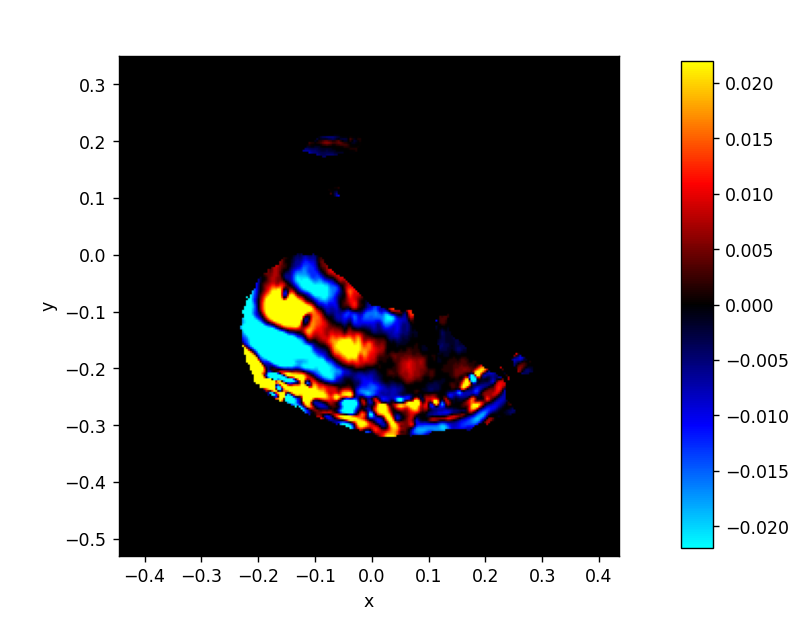

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


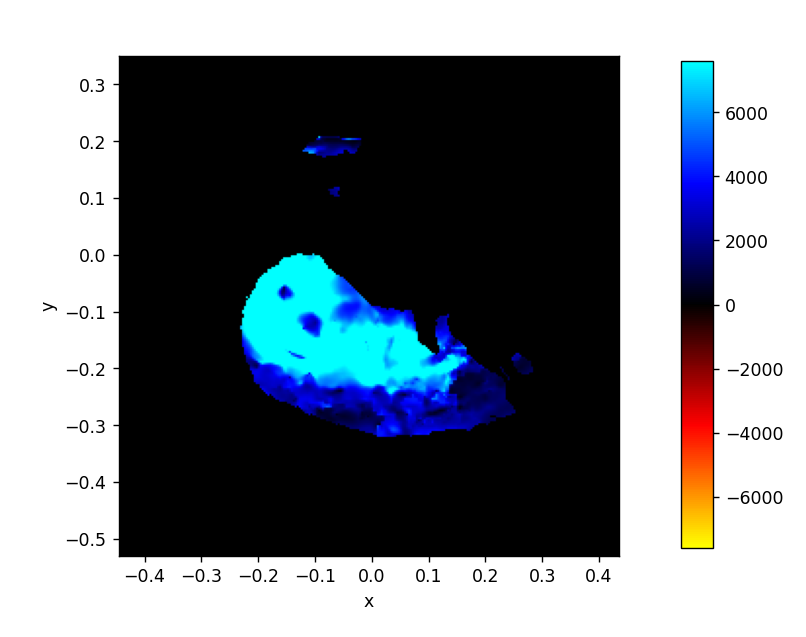

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


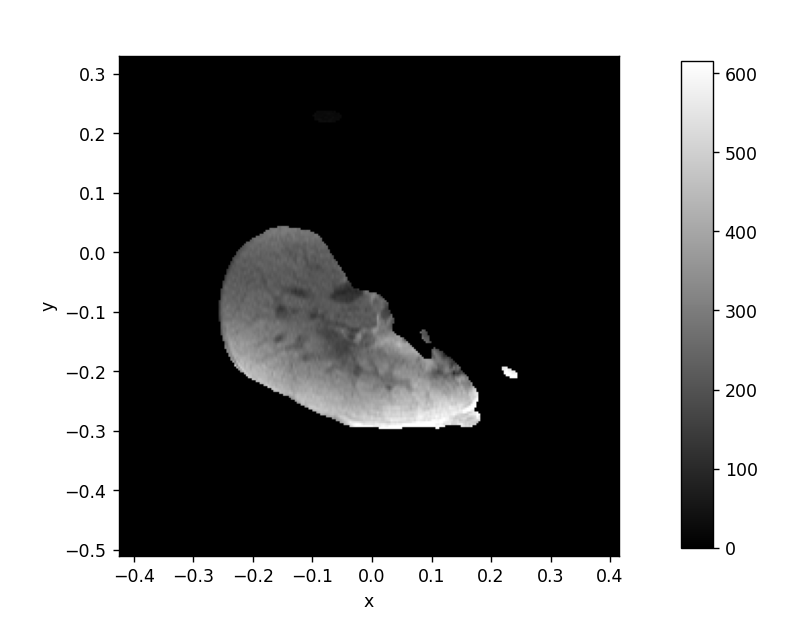

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [24]:
%autoreload
dataset[0].view('wave', 'mre', 'anat', mask=True)